# Network topologies and mobility in the ns-3 simulator

Let's start by importing the ns-3 bindings.

In [1]:
import sys
import os

# You must run jupyter from the ns-3-dev directory, 
# or adjust these paths to the absolute directory path of ns-3-dev
sys.path.append("./ns-3-dev/build/bindings/python")
sys.path.append("./ns-3-dev/build/lib")

from ns import ns

Now let's define a function that plots the network node positions.

In [2]:
from matplotlib import pyplot as plt

# Get the coordinates for each node in the NodeContainer and plot
def plotNodePosition(nodeContainer : ns.NodeContainer, showLegend: bool = True) -> None:
    for node_i in range(nodeContainer.GetN()):
        node = nodeContainer.Get(node_i).__deref__()
        mobility = node.GetObject[ns.MobilityModel]().__deref__()
        position = mobility.GetPosition()
        plt.scatter((position.x), (position.y), label=f"Node {node.GetId()}")
    plt.ylabel("Y (m)")
    plt.xlabel("X (m)")
    if showLegend:
        plt.legend()
    plt.show()

Now we can create and visualize a few static topologies.

Let's try a very simple topology with 10 nodes divided in two lines.

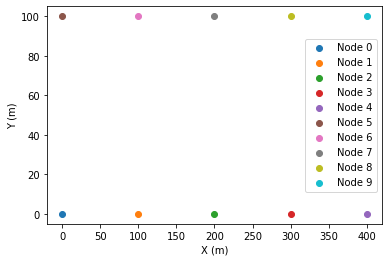

In [3]:
def plotNodesInLineTopology():
    ns.Simulator.Destroy()
    
    # Create a topology with two rows with 5 nodes
    nodes = ns.NodeContainer()
    nodes.Create(10)

    linePositions = ns.CreateObject("ListPositionAllocator")
    for line in range(2):
        for column in range(5):
            linePositions.__deref__().Add (ns.Vector(100*column, 100*line, 0))

    mobilityHelper = ns.MobilityHelper()
    mobilityHelper.SetMobilityModel ("ns3::ConstantPositionMobilityModel")
    mobilityHelper.SetPositionAllocator (linePositions)
    mobilityHelper.Install (nodes)

    plotNodePosition(nodes)

plotNodesInLineTopology()

Now let's try something more complicated. We can pass the coordinates for each individual node, to setup whatever topology we want. In this case, we are going to allocate the 10 nodes into a circle with radius of 100 meters.

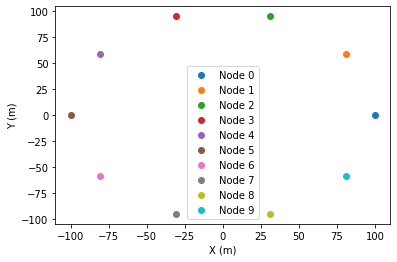

In [4]:
def plotNodesInCircleTopology():
    import math
    ns.Simulator.Destroy()
    
    # Create a circular topology
    nodes = ns.NodeContainer()
    nodes.Create(10)

    linePositions = ns.CreateObject("ListPositionAllocator")
    radius = 100
    degPerNode = 2*math.pi / nodes.GetN()
    for node_i in range(nodes.GetN()):
        linePositions.__deref__().Add (ns.Vector(radius*math.cos(degPerNode*node_i),
                                                 radius*math.sin(degPerNode*node_i),
                                                 0))

    mobilityHelper = ns.MobilityHelper()
    mobilityHelper.SetMobilityModel ("ns3::ConstantPositionMobilityModel")
    mobilityHelper.SetPositionAllocator (linePositions)
    mobilityHelper.Install (nodes)

    plotNodePosition(nodes)

plotNodesInCircleTopology()

There are some topologies that are very common, and have their specific helpers. For example, the point-to-point network interface has a star topology helper, that allocates nodes around a central hub in the center, and connects each of the nodes to the hub with a point-to-point link.

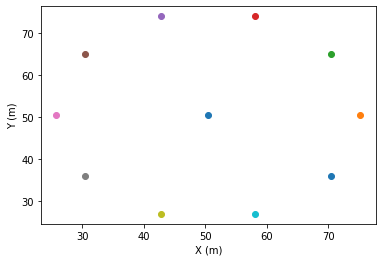

In [5]:
def plotNodesInStarTopology():
    ns.Simulator.Destroy()
    
    # Create point-to-point star topology with 20 nodes
    pointToPoint = ns.PointToPointHelper()
    star = ns.PointToPointStarHelper(10, pointToPoint)
    star.BoundingBox(1, 1, 100, 100);

    # Get node container to plot the topology
    nodes = ns.NodeContainer()
    nodes.Add(star.GetHub())
    for node_i in range(star.SpokeCount()):
        nodes.Add(star.GetSpokeNode(node_i))
        
    plotNodePosition(nodes, showLegend=False)
    
plotNodesInStarTopology()

Another example of such helpers is the grid topology helper, also for point-to-point.

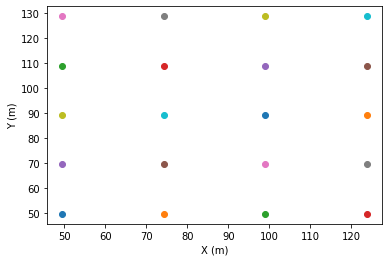

In [6]:
def plotNodesInGridTopology():
    ns.Simulator.Destroy()
    
    # Create point-to-point grid topology with 20 nodes
    pointToPoint = ns.PointToPointHelper()
    grid = ns.PointToPointGridHelper(5,4, pointToPoint)
    grid.BoundingBox(1, 1, 100, 100);

    # Get node container to plot the topology
    nodes = ns.NodeContainer()
    for node_i in range(5):
        for node_j in range(4):
            nodes.Add(grid.GetNode(node_i, node_j))
        
    plotNodePosition(nodes, showLegend=False)
    
plotNodesInGridTopology()

All of these topologies were static.
For some scenarios, this might be OK.
For mobile networks in urban scenarios, that isn't very realistic.
We can add some mobility to increase the realism.

To plot the moving nodes, we need a new function.

In [7]:
coordinatesHistoric = []

# Create an event in C++ for the following python function
ns.cppyy.cppdef("""
   namespace ns3
   {
       EventImpl* pythonMakeEvent(void (*f)(NodeContainer&), NodeContainer& nodes)
       {
           return MakeEvent(f, nodes);
       }
   }
""")

def getNodeCoordinates(nodeContainer : ns.NodeContainer) -> None:
    global coordinatesHistoric

    coordinates = {}
    for node_i in range(nodeContainer.GetN()):
        node = nodeContainer.Get(node_i).__deref__()
        mobility = node.GetObject[ns.MobilityModel]().__deref__()
        position = mobility.GetPosition()
        coordinates[f"Node {node.GetId()}"] = ((position.x), (position.y))
    coordinatesHistoric.append((ns.Simulator.Now().GetSeconds(), coordinates))

    # Re-schedule after every 1 second
    event = ns.pythonMakeEvent(getNodeCoordinates, nodeContainer)
    ns.Simulator.Schedule(ns.Seconds(1), event)
    
def animateSimulation():
    global coordinatesHistoric
    
    # Save a copy and clean historic for the next animation
    coordinatesHistoricCopy = coordinatesHistoric
    coordinatesHistoric = []
    
    # Animate coordinates from the simulation
    from matplotlib import pyplot as plt
    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML
    
    fig = plt.figure()
    plots = {}
    def init():
        # Initialize animation artists
        for (node, coordinate) in coordinatesHistoricCopy[0][1].items():
            plots[node] = plt.scatter(*coordinate, label=node)

        # Determine animation bounds
        x_bounds = [0,0]
        y_bounds = [0,0]
        for i in range(len(coordinatesHistoricCopy)):
            for (node, coordinate) in coordinatesHistoricCopy[i][1].items():
                if (coordinate[0] > x_bounds[1]):
                    x_bounds[1] = coordinate[0]
                if (coordinate[1] > y_bounds[1]):
                    y_bounds[1] = coordinate[1]
                    
        # Add a margin to the bounds
        x_bounds[0] -= 1
        y_bounds[0] -= 1
        x_bounds[1] += 1
        y_bounds[1] += 1
        
        # Set animation bounds
        plt.xlim(x_bounds)
        plt.ylim(y_bounds)

    def animate(i):
        for (node, coordinate) in coordinatesHistoricCopy[i][1].items():
            plots[node].set_offsets(coordinate)
    
    # Animate the historic of coordinates
    anim = FuncAnimation(fig, animate, init_func=init,
                         frames = len(coordinatesHistoricCopy),
                         interval = 100, repeat=True)
    
    # Display the interactive animation
    display(HTML(anim.to_jshtml()))
    
    # Prevent plotting the final frame as a static image
    plt.close()
    return

This was quite more complicated than I've imagined, but works well enough.

Let's try to see if really works.

In [8]:
# Test the animation
coordinatesHistoric = [(0.0, {"Node 1": ((0.0), (0.0))}),
                       (1.0, {"Node 1": ((10.0), (0.0))}),
                       (2.0, {"Node 1": ((10.0), (10.0))}),
                       (3.0, {"Node 1": ((0.0), (10.0))}),
                       ]
animateSimulation()

Now that we have seen it working, let's try it with a real simulation.

This case is the same with two rows we saw at the beginning, but now the nodes go towards the opposite row, crossing in the center.

In [9]:
def animateConstantVelocityNodesInLineTopology():
    ns.Simulator.Destroy()

    # Create a topology with two rows with 5 nodes
    nodes = ns.NodeContainer()
    nodes.Create(10)

    linePositions = ns.CreateObject("ListPositionAllocator")
    for line in range(2):
        for column in range(5):
            linePositions.__deref__().Add (ns.Vector(100*column, 100*line, 0))

    mobilityHelper = ns.MobilityHelper()
    mobilityHelper.SetMobilityModel ("ns3::ConstantVelocityMobilityModel")
    mobilityHelper.SetPositionAllocator (linePositions)
    mobilityHelper.Install (nodes)
    
    # Set node velocities
    for line in range(2):
        for column in range(5):
            node = nodes.Get(line*5+column).__deref__()
            mobility = node.GetObject[ns.MobilityModel]().__deref__()
            mobility.SetVelocity(ns.Vector(0, 1 if line == 0 else -1, 0));
    

    # Schedule getNodeCoordinates to run after 1 second of simulation
    event = ns.pythonMakeEvent(getNodeCoordinates, nodes)
    ns.Simulator.Schedule(ns.Seconds(1), event)

    # Run simulation for 100 virtual seconds
    ns.Simulator.Stop(ns.Seconds(100))
    ns.Simulator.Run()
    
    animateSimulation()

animateConstantVelocityNodesInLineTopology()

We can also use use the random walk mobility model.

In [10]:
def animateRandomWalkNodes():
    ns.Simulator.Destroy()

    # Create a topology with two rows with 5 nodes
    nodes = ns.NodeContainer()
    nodes.Create(10)

    # Some allocators allows us to specify a few parameters,
    # that are used along random variables to determine the position for each node
    randomBoxPositions = ns.CreateObject("RandomBoxPositionAllocator")
    randomBoxPositions.SetAttribute("X", ns.StringValue("ns3::UniformRandomVariable[Min=0.0|Max=100.0]"));
    randomBoxPositions.SetAttribute("Y", ns.StringValue("ns3::UniformRandomVariable[Min=0.0|Max=100.0]"));
    randomBoxPositions.SetAttribute("Z", ns.StringValue("ns3::UniformRandomVariable[Min=0.0|Max=1.0]"));

    mobilityHelper = ns.MobilityHelper()
    mobilityHelper.SetMobilityModel ("ns3::RandomWalk2dMobilityModel")
    mobilityHelper.SetPositionAllocator (randomBoxPositions)
    mobilityHelper.Install (nodes)  

    # Schedule getNodeCoordinates to run after 1 second of simulation
    event = ns.pythonMakeEvent(getNodeCoordinates, nodes)
    ns.Simulator.Schedule(ns.Seconds(1), event)

    # Run simulation for 100 virtual seconds
    ns.Simulator.Stop(ns.Seconds(100))
    ns.Simulator.Run()
    
    animateSimulation()

animateRandomWalkNodes()

If none of the available mobility models are a good fit for your use-case, you can implement your own. For example, using the waypoint mobility model.

In [11]:
def animateWaypointWalkNodes():
    ns.Simulator.Destroy()

    import math

    # Create a topology with two rows with 5 nodes
    nodes = ns.NodeContainer()
    nodes.Create(10)

    # Some allocators allows us to specify a few parameters,
    # that are used along random variables to determine the position for each node
    randomBoxPositions = ns.CreateObject("RandomBoxPositionAllocator")
    randomBoxPositions.SetAttribute("X", ns.StringValue("ns3::UniformRandomVariable[Min=0.0|Max=100.0]"));
    randomBoxPositions.SetAttribute("Y", ns.StringValue("ns3::UniformRandomVariable[Min=0.0|Max=100.0]"));
    randomBoxPositions.SetAttribute("Z", ns.StringValue("ns3::UniformRandomVariable[Min=0.0|Max=1.0]"));

    mobilityHelper = ns.MobilityHelper()
    mobilityHelper.SetMobilityModel ("ns3::WaypointMobilityModel")
    mobilityHelper.SetPositionAllocator (randomBoxPositions)
    mobilityHelper.Install (nodes)

    # We need to setup the waypoints each node will walk on
    # In this case, we are going to make them walk in
    # the DVD Logo fashion
    for node_i in range(nodes.GetN()):
        node = nodes.Get(node_i).__deref__()
        mobility = node.GetObject[ns.WaypointMobilityModel]().__deref__()
        currPos = mobility.GetPosition()
        time = ns.Seconds(0.5)
        DIR = [1,1]
        while time.GetSeconds() < 100:
            dirChanged = False
            nextPos = ns.Vector(currPos.x+(2 if DIR[0] else -2),
                                currPos.y+(2 if DIR[1] else -2),
                                0
                                )
            if DIR[0] == 0:
                if nextPos.x < 0:
                    DIR[0] = 1
                    dirChanged = True
            else:
                if nextPos.x > 100:
                    DIR[0] = 0
                    dirChanged = True

            if DIR[1] == 0:
                if nextPos.y < 0:
                    DIR[1] = 1
                    dirChanged = True
            else:
                if nextPos.y > 100:
                    DIR[1] = 0
                    dirChanged = True

            # Skip next position since it goes out of bounds
            if dirChanged:
                continue
            time = ns.Seconds(1+time.GetSeconds())
            wpt = ns.Waypoint (time, nextPos);
            mobility.AddWaypoint(wpt)
            currPos = nextPos


    # Schedule getNodeCoordinates to run after 1 second of simulation
    event = ns.pythonMakeEvent(getNodeCoordinates, nodes)
    ns.Simulator.Schedule(ns.Seconds(1), event)

    # Run simulation for 100 virtual seconds
    ns.Simulator.Stop(ns.Seconds(100))
    ns.Simulator.Run()

    animateSimulation()

animateWaypointWalkNodes()